# On Deck Member-to-Company Conversion Analysis Plan

## Major Assumptions
We assume the On Deck database contains member/alumni records with cohort identifiers, company founding data, fundraising amounts, and engagement metrics (event attendance, platform activity, etc.). We'll define "conversion" as members who founded or co-founded companies post-fellowship, and analyze this by cohort vintage to identify trends and correlations with engagement behavior.

## Plan
- [x] Explore database schema and identify key tables
  - [x] Map relationships between members, cohorts, companies, fundraising rounds, and engagement events
  - [x] Assess data completeness and define inclusion criteria for analysis
- [x] Calculate member-to-company conversion rates by cohort
  - [x] Define conversion metric and compute rates across cohort vintages
  - [x] Visualize conversion trends over time with cohort comparison charts
- [x] Analyze correlation between alumni fundraising and engagement
  - [x] Aggregate fundraising totals and engagement scores per alumni
  - [x] Compute correlations and create scatter plots with regression analysis
- [x] Synthesize findings and identify actionable insights
  - [x] Identify high-performing cohorts and engagement patterns linked to success

In [1]:
# On Deck: Member-to-Company Conversion & Fundraising Analysis
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'figure.titlesize': 16, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
          'blue': '#73acfb', 'red': '#c45757', 'yellow': '#fec163', 'green': '#4ca86f'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to On Deck database
engine = create_engine(os.environ['ON_DECK_CONNECTION_URL'])

# Load all tables
members = pd.read_sql("SELECT * FROM members", engine)
outcomes = pd.read_sql("SELECT * FROM outcomes", engine)
engagements = pd.read_sql("SELECT * FROM engagements", engine)
fellowships = pd.read_sql("SELECT * FROM fellowships", engine)
engine.dispose()

print(f"Members: {len(members):,} | Outcomes: {len(outcomes):,} | Engagements: {len(engagements):,} | Fellowships: {len(fellowships):,}")

Members: 3,000 | Outcomes: 1,931 | Engagements: 50,000 | Fellowships: 80


In [2]:
# Identify members who founded companies (have 'company_founded' outcome)
founders = outcomes[outcomes['outcome_type'] == 'company_founded']['member_id'].unique()

# Add conversion flag to members
members['founded_company'] = members['id'].isin(founders)

# Calculate conversion rate by program and cohort
conversion_by_cohort = members.groupby(['program', 'cohort_number']).agg(
    total_members=('id', 'count'),
    founders=('founded_company', 'sum')
).reset_index()
conversion_by_cohort['conversion_rate'] = conversion_by_cohort['founders'] / conversion_by_cohort['total_members'] * 100

# Display by program
for program in conversion_by_cohort['program'].unique():
    prog_data = conversion_by_cohort[conversion_by_cohort['program'] == program]
    avg_rate = prog_data['conversion_rate'].mean()
    print(f"{program}: {len(prog_data)} cohorts, avg conversion: {avg_rate:.1f}%")

ODA: 18 cohorts, avg conversion: 18.7%
ODE: 17 cohorts, avg conversion: 34.1%
ODF: 25 cohorts, avg conversion: 41.6%
ODX: 20 cohorts, avg conversion: 27.9%


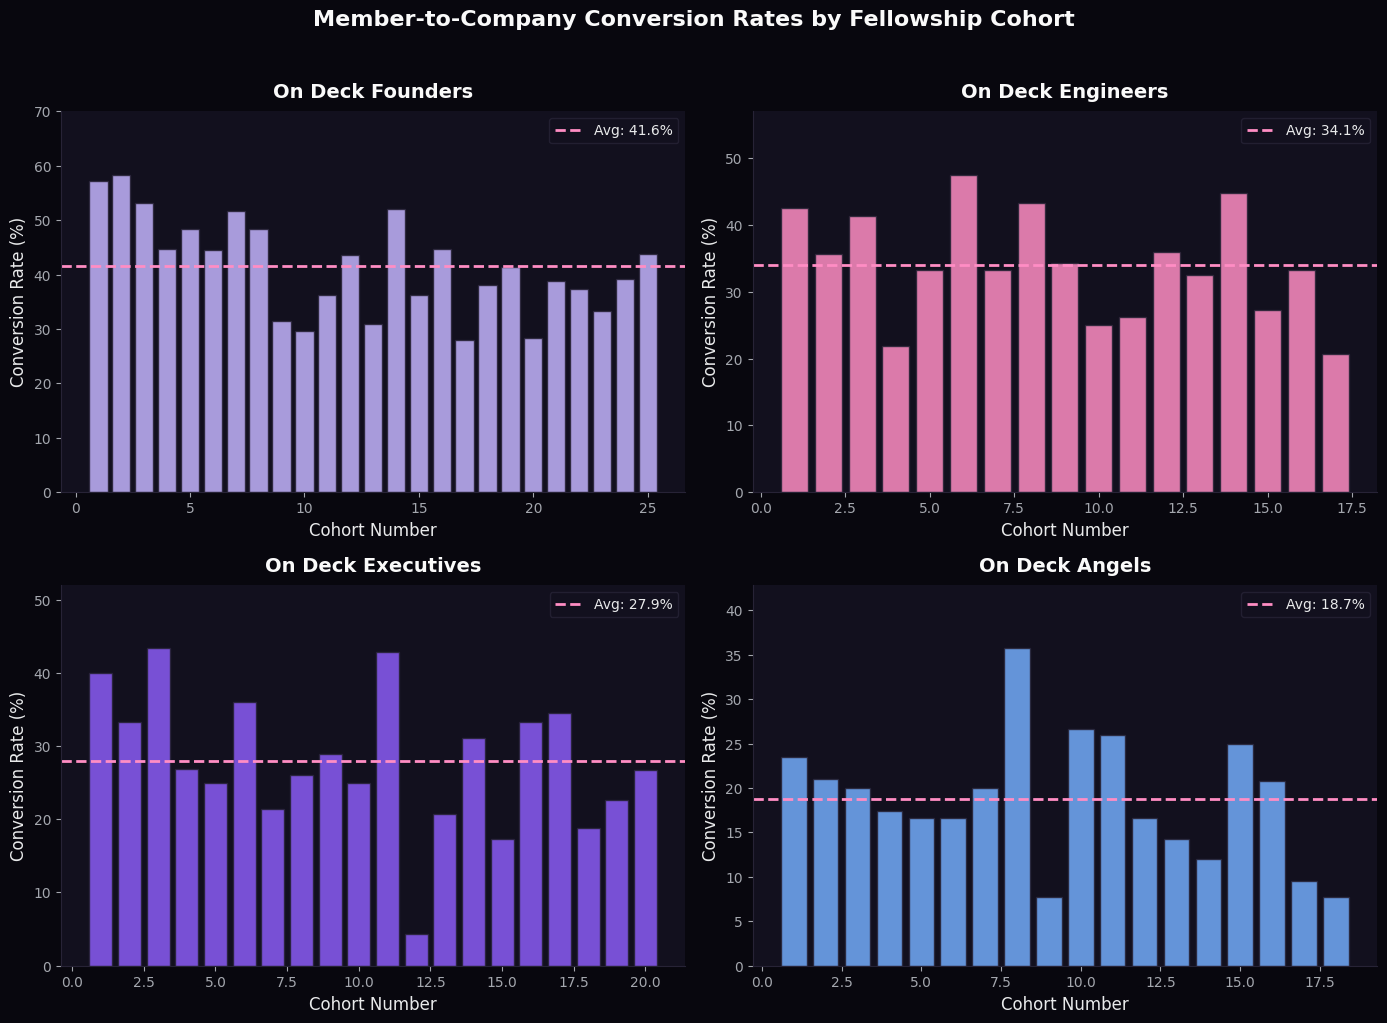

In [3]:
# Visualize conversion rates by cohort for each program
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

program_names = {'ODF': 'On Deck Founders', 'ODE': 'On Deck Engineers', 
                 'ODA': 'On Deck Angels', 'ODX': 'On Deck Executives'}

for i, program in enumerate(['ODF', 'ODE', 'ODX', 'ODA']):
    ax = axes[i]
    prog_data = conversion_by_cohort[conversion_by_cohort['program'] == program].sort_values('cohort_number')
    
    bars = ax.bar(prog_data['cohort_number'], prog_data['conversion_rate'], 
                  color=CATEGORICAL_PALETTE[i], alpha=0.85, edgecolor='#272336')
    
    avg_rate = prog_data['conversion_rate'].mean()
    ax.axhline(avg_rate, color=COLORS['secondary'], linestyle='--', linewidth=2, label=f'Avg: {avg_rate:.1f}%')
    
    ax.set_xlabel('Cohort Number')
    ax.set_ylabel('Conversion Rate (%)')
    ax.set_title(f'{program_names.get(program, program)}', fontweight='bold', pad=10)
    ax.legend(loc='upper right', frameon=True)
    ax.set_ylim(0, max(prog_data['conversion_rate']) * 1.2)

plt.suptitle('Member-to-Company Conversion Rates by Fellowship Cohort', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [4]:
# Calculate engagement metrics per member
engagement_counts = engagements.groupby('member_id').agg(
    total_engagements=('id', 'count'),
    intros_made=('event_type', lambda x: (x == 'intro_made').sum()),
    events_attended=('event_type', lambda x: (x == 'event_attended').sum()),
    office_hours=('event_type', lambda x: (x == 'office_hours').sum()),
    slack_messages=('event_type', lambda x: (x == 'slack_message').sum())
).reset_index()

# Get fundraising totals per member (alumni who raised money)
fundraising = outcomes[outcomes['outcome_type'] == 'fundraise'].groupby('member_id').agg(
    total_raised=('amount_usd', 'sum'),
    num_rounds=('id', 'count')
).reset_index()

# Merge engagement with fundraising data
alumni_analysis = engagement_counts.merge(fundraising, on='member_id', how='inner')
alumni_analysis = alumni_analysis.merge(members[['id', 'program', 'status']], left_on='member_id', right_on='id')

print(f"Alumni with both engagement & fundraising data: {len(alumni_analysis):,}")
print(f"\nFundraising summary:")
print(f"  Total raised: ${alumni_analysis['total_raised'].sum():,.0f}")
print(f"  Median raise: ${alumni_analysis['total_raised'].median():,.0f}")
print(f"  Avg engagements: {alumni_analysis['total_engagements'].mean():.1f}")

Alumni with both engagement & fundraising data: 565

Fundraising summary:
  Total raised: $1,060,463,168
  Median raise: $1,707,586
  Avg engagements: 17.4


Correlation with Total Raised:
----------------------------------------
  total_engagements   : r = +0.563 ***
  intros_made         : r = +0.538 ***
  events_attended     : r = +0.538 ***
  office_hours        : r = +0.483 ***
  slack_messages      : r = +0.527 ***


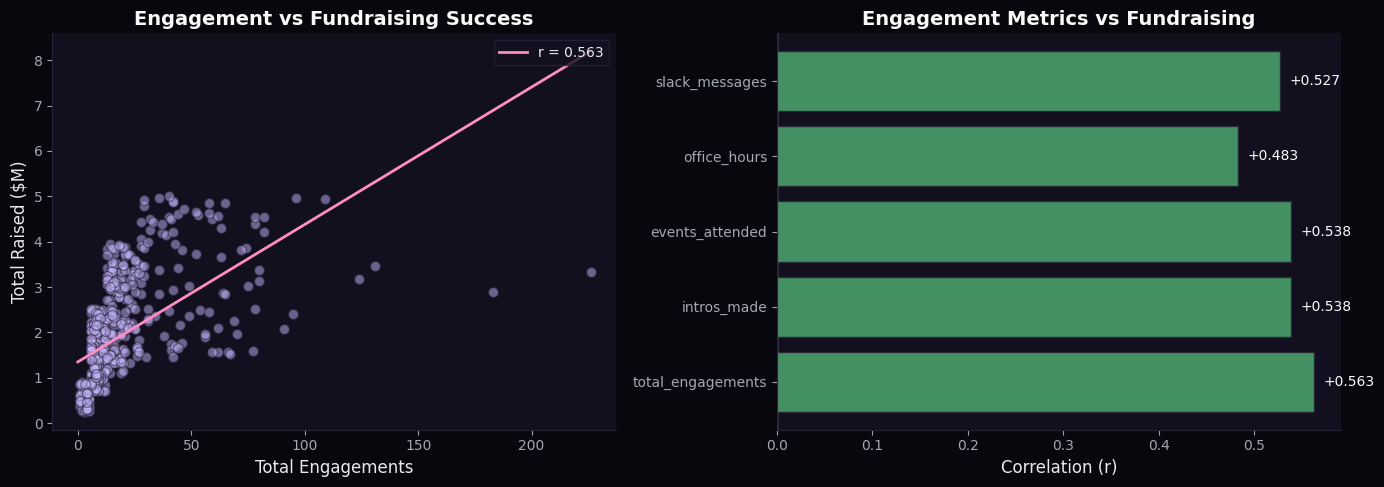

In [6]:
# Correlation analysis between engagement metrics and fundraising
engagement_cols = ['total_engagements', 'intros_made', 'events_attended', 'office_hours', 'slack_messages']

print("Correlation with Total Raised:")
print("-" * 40)
correlations = {}
for col in engagement_cols:
    r, p = stats.pearsonr(alumni_analysis[col], alumni_analysis['total_raised'])
    correlations[col] = r
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    print(f"  {col:20s}: r = {r:+.3f} {sig}")

# Visualize: scatter plot with regression for total engagements vs fundraising
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Scatter plot
ax = axes[0]
ax.scatter(alumni_analysis['total_engagements'], alumni_analysis['total_raised'] / 1e6, 
           alpha=0.5, color=COLORS['primary'], edgecolors='#272336', s=50)

# Add regression line
slope, intercept, r, p, se = stats.linregress(alumni_analysis['total_engagements'], alumni_analysis['total_raised'] / 1e6)
x_line = np.array([0, alumni_analysis['total_engagements'].max()])
ax.plot(x_line, slope * x_line + intercept, color=COLORS['secondary'], linewidth=2, label=f'r = {r:.3f}')

ax.set_xlabel('Total Engagements')
ax.set_ylabel('Total Raised ($M)')
ax.set_title('Engagement vs Fundraising Success', fontweight='bold')
ax.legend(loc='upper right')

# Right: Correlation bar chart
ax = axes[1]
colors = [COLORS['green'] if v > 0 else COLORS['red'] for v in correlations.values()]
bars = ax.barh(list(correlations.keys()), list(correlations.values()), color=colors, alpha=0.85, edgecolor='#272336')
ax.axvline(0, color='#a4a7ae', linewidth=1)
ax.set_xlabel('Correlation (r)')
ax.set_title('Engagement Metrics vs Fundraising', fontweight='bold')

for bar, val in zip(bars, correlations.values()):
    ax.text(val + 0.01 if val > 0 else val - 0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:+.3f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

In [8]:
# Load invoices for renewal analysis
invoices = pd.read_sql("SELECT * FROM invoices", engine)
engine.dispose()

# Method 1: Status-based retention (active + alumni = retained, churned = lost)
status_retention = members.groupby('program', as_index=False).agg(
    total=('id', 'count'),
    retained=('status', lambda x: ((x == 'active') | (x == 'alumni')).sum()),
    churned=('status', lambda x: (x == 'churned').sum())
)
status_retention['retention_rate'] = status_retention['retained'] / status_retention['total'] * 100

# Method 2: Invoice-based renewal rate (members who paid annual_membership after fellowship_fee)
member_invoices = invoices.merge(members[['id', 'program']], left_on='member_id', right_on='id')

# Calculate renewal rate by program
renewal_by_program = []
for prog in members['program'].unique():
    prog_fellowship = member_invoices[(member_invoices['plan_type'] == 'fellowship_fee') & 
                                       (member_invoices['program'] == prog)]['member_id'].unique()
    prog_renewed = member_invoices[(member_invoices['member_id'].isin(prog_fellowship)) & 
                                    (member_invoices['plan_type'] == 'annual_membership') &
                                    (member_invoices['program'] == prog)]['member_id'].unique()
    renewal_by_program.append({
        'program': prog,
        'fellowship_members': len(prog_fellowship),
        'renewed': len(prog_renewed),
        'renewal_rate': len(prog_renewed) / len(prog_fellowship) * 100 if len(prog_fellowship) > 0 else 0
    })

renewal_df = pd.DataFrame(renewal_by_program).sort_values('renewal_rate', ascending=False)

/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_6181/864051576.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([program_labels.get(p, p) for p in ax.get_yticklabels()])
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_6181/864051576.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([program_labels.get(p, p) for p in ax.get_yticklabels()])


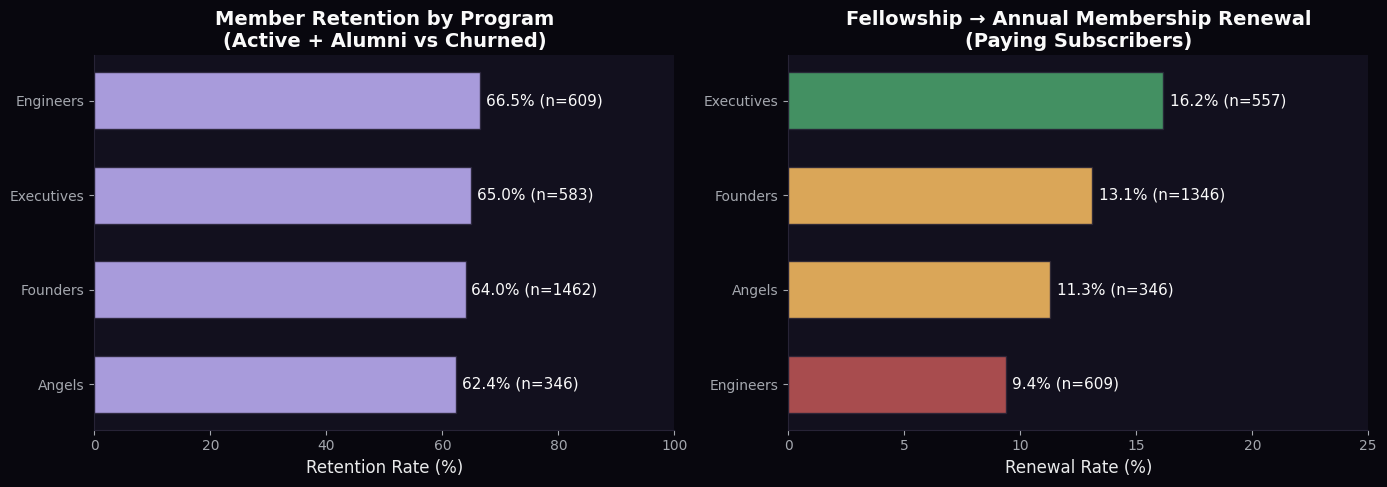


RETENTION SUMMARY BY PROGRAM

Executives (ODX):
  Status retention: 65.0% (379/583)
  Renewal rate:     16.2% (90/557)

Founders (ODF):
  Status retention: 64.0% (936/1462)
  Renewal rate:     13.1% (176/1346)

Angels (ODA):
  Status retention: 62.4% (216/346)
  Renewal rate:     11.3% (39/346)

Engineers (ODE):
  Status retention: 66.5% (405/609)
  Renewal rate:     9.4% (57/609)


In [9]:
# Visualize retention and renewal rates by program
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Status-based retention rate
ax = axes[0]
status_sorted = status_retention.sort_values('retention_rate', ascending=True)
bars = ax.barh(status_sorted['program'], status_sorted['retention_rate'], 
               color=COLORS['primary'], alpha=0.85, edgecolor='#272336', height=0.6)
ax.set_xlabel('Retention Rate (%)')
ax.set_title('Member Retention by Program\n(Active + Alumni vs Churned)', fontweight='bold')
ax.set_xlim(0, 100)

for bar, val, total in zip(bars, status_sorted['retention_rate'], status_sorted['total']):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}% (n={total})', va='center', fontsize=11)

# Right: Invoice-based renewal rate (fellowship → annual)
ax = axes[1]
renewal_sorted = renewal_df.sort_values('renewal_rate', ascending=True)
colors_renewal = [COLORS['green'] if r > 14 else COLORS['yellow'] if r > 11 else COLORS['red'] 
                  for r in renewal_sorted['renewal_rate']]
bars = ax.barh(renewal_sorted['program'], renewal_sorted['renewal_rate'], 
               color=colors_renewal, alpha=0.85, edgecolor='#272336', height=0.6)
ax.set_xlabel('Renewal Rate (%)')
ax.set_title('Fellowship → Annual Membership Renewal\n(Paying Subscribers)', fontweight='bold')
ax.set_xlim(0, 25)

for bar, val, n in zip(bars, renewal_sorted['renewal_rate'], renewal_sorted['fellowship_members']):
    ax.text(val + 0.3, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}% (n={n})', va='center', fontsize=11)

# Add program labels
program_labels = {'ODF': 'Founders', 'ODE': 'Engineers', 'ODA': 'Angels', 'ODX': 'Executives'}
for ax in axes:
    ax.set_yticklabels([program_labels.get(p, p) for p in ax.get_yticklabels()])
    yticks = ax.get_yticks()
    ax.set_yticks(yticks)
    ax.set_yticklabels([program_labels.get(t.get_text(), t.get_text()) for t in ax.get_yticklabels()])

plt.tight_layout()
plt.show()

# Summary stats
print("\n" + "="*60)
print("RETENTION SUMMARY BY PROGRAM")
print("="*60)
for _, row in renewal_df.iterrows():
    prog_name = program_labels.get(row['program'], row['program'])
    status_row = status_retention[status_retention['program'] == row['program']].iloc[0]
    print(f"\n{prog_name} ({row['program']}):")
    print(f"  Status retention: {status_row['retention_rate']:.1f}% ({status_row['retained']}/{status_row['total']})")
    print(f"  Renewal rate:     {row['renewal_rate']:.1f}% ({row['renewed']}/{row['fellowship_members']})")

In [10]:
# Build comprehensive engagement-outcomes analysis
# Get all outcome types
outcome_types = outcomes['outcome_type'].unique()
print(f"Outcome types: {list(outcome_types)}")

# Create outcome flags per member
member_outcomes = members[['id', 'program']].copy()
for ot in outcome_types:
    member_outcomes[ot] = member_outcomes['id'].isin(
        outcomes[outcomes['outcome_type'] == ot]['member_id']
    ).astype(int)

# Merge with engagement data
full_analysis = engagement_counts.merge(member_outcomes, left_on='member_id', right_on='id', how='left')
full_analysis = full_analysis.fillna(0)

print(f"\nMembers with engagement data: {len(full_analysis):,}")
print(f"\nOutcome rates:")
for ot in outcome_types:
    rate = full_analysis[ot].mean() * 100
    print(f"  {ot:20s}: {rate:.1f}%")

Outcome types: ['company_founded', 'fundraise', 'job_placed', 'acquisition']

Members with engagement data: 2,987

Outcome rates:
  company_founded     : 34.7%
  fundraise           : 18.9%
  job_placed          : 9.4%
  acquisition         : 1.3%


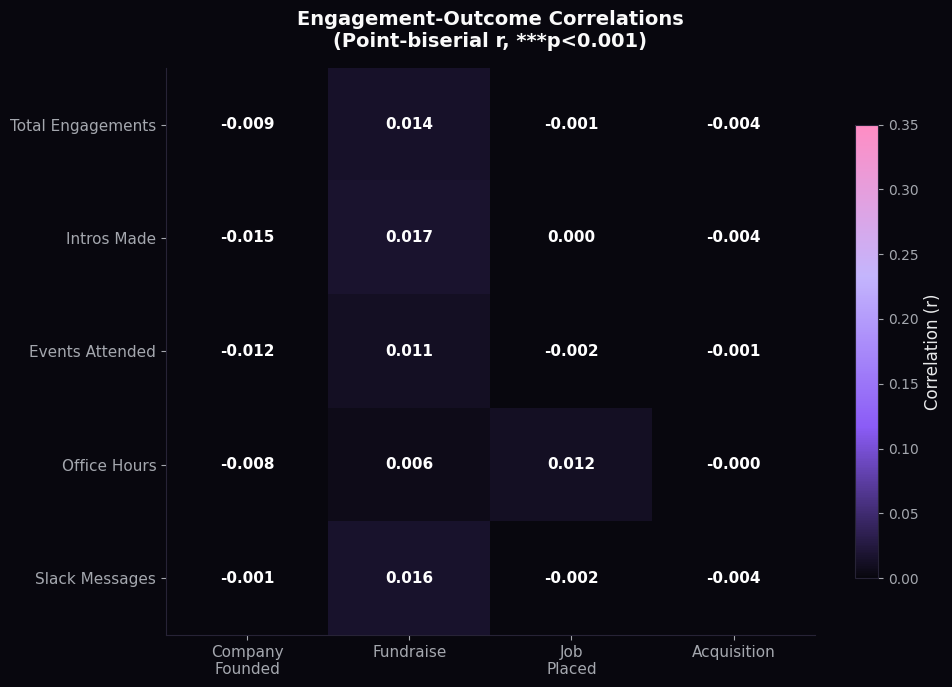

In [11]:
# Compute correlation matrix: engagement metrics vs outcomes
from scipy import stats

engagement_cols = ['total_engagements', 'intros_made', 'events_attended', 'office_hours', 'slack_messages']
outcome_cols = ['company_founded', 'fundraise', 'job_placed', 'acquisition']

# Calculate point-biserial correlations (continuous vs binary)
corr_matrix = pd.DataFrame(index=engagement_cols, columns=outcome_cols, dtype=float)
pval_matrix = pd.DataFrame(index=engagement_cols, columns=outcome_cols, dtype=float)

for eng in engagement_cols:
    for out in outcome_cols:
        r, p = stats.pointbiserialr(full_analysis[out], full_analysis[eng])
        corr_matrix.loc[eng, out] = r
        pval_matrix.loc[eng, out] = p

# Visualize correlation heatmap
fig, ax = plt.subplots(figsize=(10, 7))

# Custom colormap (dark → purple → pink)
from matplotlib.colors import LinearSegmentedColormap
sp_cmap = LinearSegmentedColormap.from_list('signalpilot', ['#08070e', '#8b5cf6', '#c4b5fd', '#ff8dc4'])

# Create heatmap with annotations
im = ax.imshow(corr_matrix.values.astype(float), cmap=sp_cmap, aspect='auto', vmin=0, vmax=0.35)

# Add correlation values with significance stars
for i, eng in enumerate(engagement_cols):
    for j, out in enumerate(outcome_cols):
        r = corr_matrix.loc[eng, out]
        p = pval_matrix.loc[eng, out]
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
        ax.text(j, i, f'{r:.3f}{sig}', ha='center', va='center', 
                color='white' if r < 0.2 else '#08070e', fontsize=11, fontweight='bold')

# Labels
ax.set_xticks(range(len(outcome_cols)))
ax.set_xticklabels(['Company\nFounded', 'Fundraise', 'Job\nPlaced', 'Acquisition'], fontsize=11)
ax.set_yticks(range(len(engagement_cols)))
ax.set_yticklabels(['Total Engagements', 'Intros Made', 'Events Attended', 'Office Hours', 'Slack Messages'], fontsize=11)
ax.set_title('Engagement-Outcome Correlations\n(Point-biserial r, ***p<0.001)', fontweight='bold', pad=15)

plt.colorbar(im, ax=ax, label='Correlation (r)', shrink=0.8)
plt.tight_layout()
plt.show()

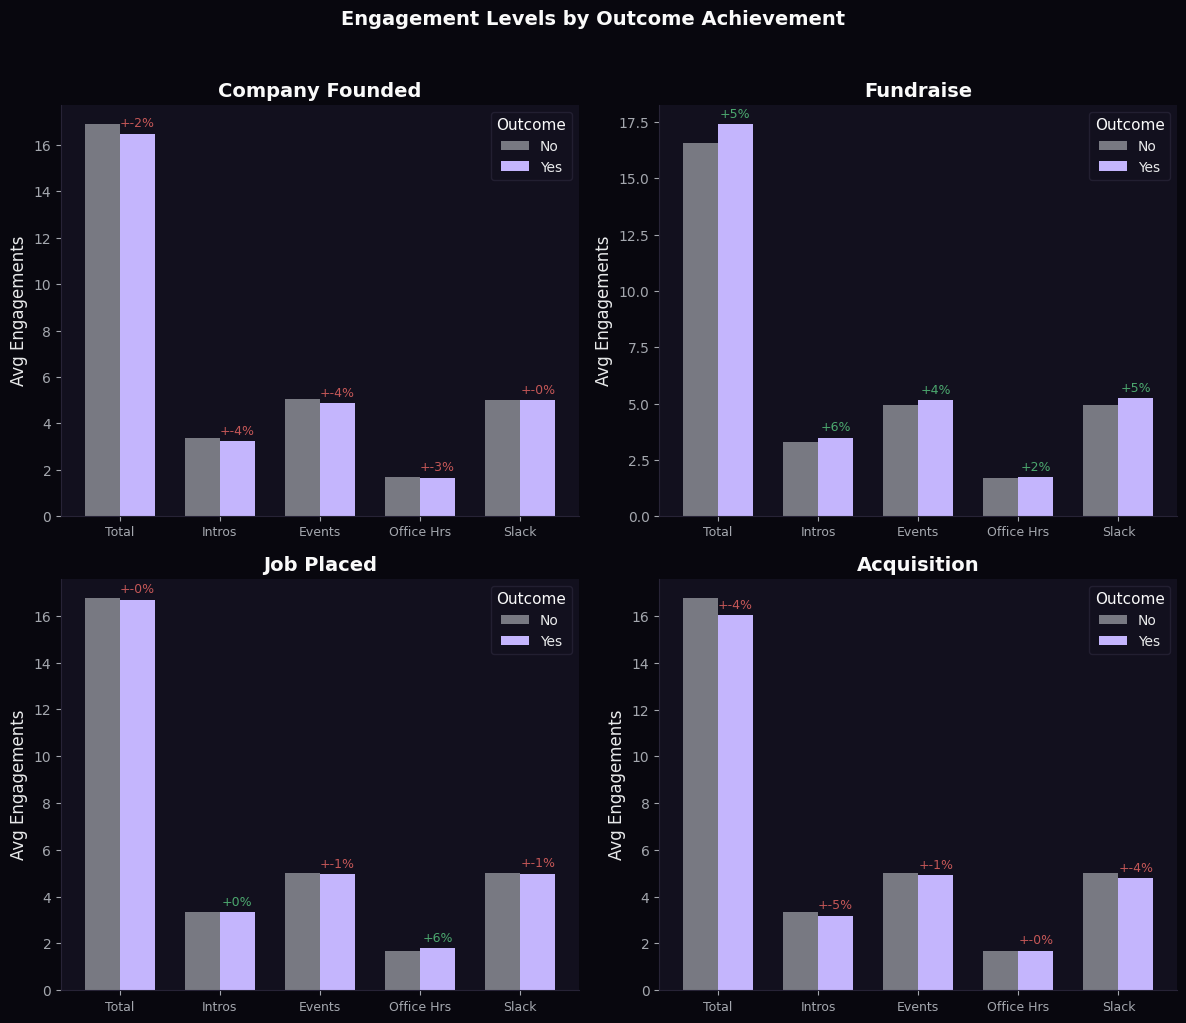


ENGAGEMENT-OUTCOME CORRELATION SUMMARY

Strongest correlations (p < 0.001):
  company_founded      ← slack_messages       (r = -0.001)
  fundraise            ← intros_made          (r = 0.017)
  job_placed           ← office_hours         (r = 0.012)
  acquisition          ← office_hours         (r = -0.000)


In [13]:
# Compare mean engagement levels for members with vs without each outcome
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, outcome in enumerate(outcome_cols):
    ax = axes[idx]
    
    # Calculate mean engagement for each group
    has_outcome = full_analysis[full_analysis[outcome] == 1][engagement_cols].mean()
    no_outcome = full_analysis[full_analysis[outcome] == 0][engagement_cols].mean()
    
    x = np.arange(len(engagement_cols))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, no_outcome.values, width, label='No', color='#a4a7ae', alpha=0.7)
    bars2 = ax.bar(x + width/2, has_outcome.values, width, label='Yes', color=COLORS['primary'])
    
    ax.set_ylabel('Avg Engagements')
    ax.set_title(outcome.replace('_', ' ').title(), fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Total', 'Intros', 'Events', 'Office Hrs', 'Slack'], fontsize=9)
    ax.legend(title='Outcome', loc='upper right')
    
    # Add percentage increase labels
    for i, (no_val, yes_val) in enumerate(zip(no_outcome.values, has_outcome.values)):
        if no_val > 0:
            pct_diff = (yes_val - no_val) / no_val * 100
            ax.text(i + width/2, yes_val + 0.3, f'+{pct_diff:.0f}%', ha='center', fontsize=9, 
                    color=COLORS['green'] if pct_diff > 0 else COLORS['red'])

plt.suptitle('Engagement Levels by Outcome Achievement', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("ENGAGEMENT-OUTCOME CORRELATION SUMMARY")
print("="*70)
print("\nStrongest correlations (p < 0.001):")
for out in outcome_cols:
    best_eng = corr_matrix[out].idxmax()
    best_r = corr_matrix[out].max()
    print(f"  {out:20s} ← {best_eng:20s} (r = {best_r:.3f})")

In [14]:
# Revenue per member analysis by year and plan type
invoices['year'] = invoices['billing_period'].str[:4].astype(int)
invoices['month'] = invoices['billing_period'].str[5:7].astype(int)

# Filter to paid invoices only
paid_invoices = invoices[invoices['payment_status'] == 'paid']

# Revenue by year and plan type
revenue_by_year = paid_invoices.groupby(['year', 'plan_type']).agg(
    total_revenue=('amount_usd', 'sum'),
    num_invoices=('id', 'count'),
    avg_invoice=('amount_usd', 'mean')
).reset_index()

# Pivot for visualization
revenue_pivot = revenue_by_year.pivot(index='year', columns='plan_type', values='total_revenue').fillna(0)
revenue_pivot['total'] = revenue_pivot.sum(axis=1)

# Calculate unique paying members per year
members_per_year = paid_invoices.groupby('year')['member_id'].nunique().reset_index()
members_per_year.columns = ['year', 'unique_members']

# Merge to get revenue per member
revenue_summary = revenue_pivot.reset_index().merge(members_per_year, on='year')
revenue_summary['revenue_per_member'] = revenue_summary['total'] / revenue_summary['unique_members']

print("Membership Revenue Summary by Year")
print("="*70)
print(revenue_summary[['year', 'fellowship_fee', 'annual_membership', 'total', 'unique_members', 'revenue_per_member']].to_string(index=False))

Membership Revenue Summary by Year
 year  fellowship_fee  annual_membership      total  unique_members  revenue_per_member
 2021      1990847.33               0.00 1990847.33             730         2727.188123
 2022      1630567.47          216902.54 1896531.21             715         2652.491203
 2023      1597676.38          252432.80 1896451.79             726         2612.192548
 2024      1455766.51          276042.16 1787184.15             673         2655.548514
 2025      1133300.32          305879.83 1487645.65             593         2508.677319


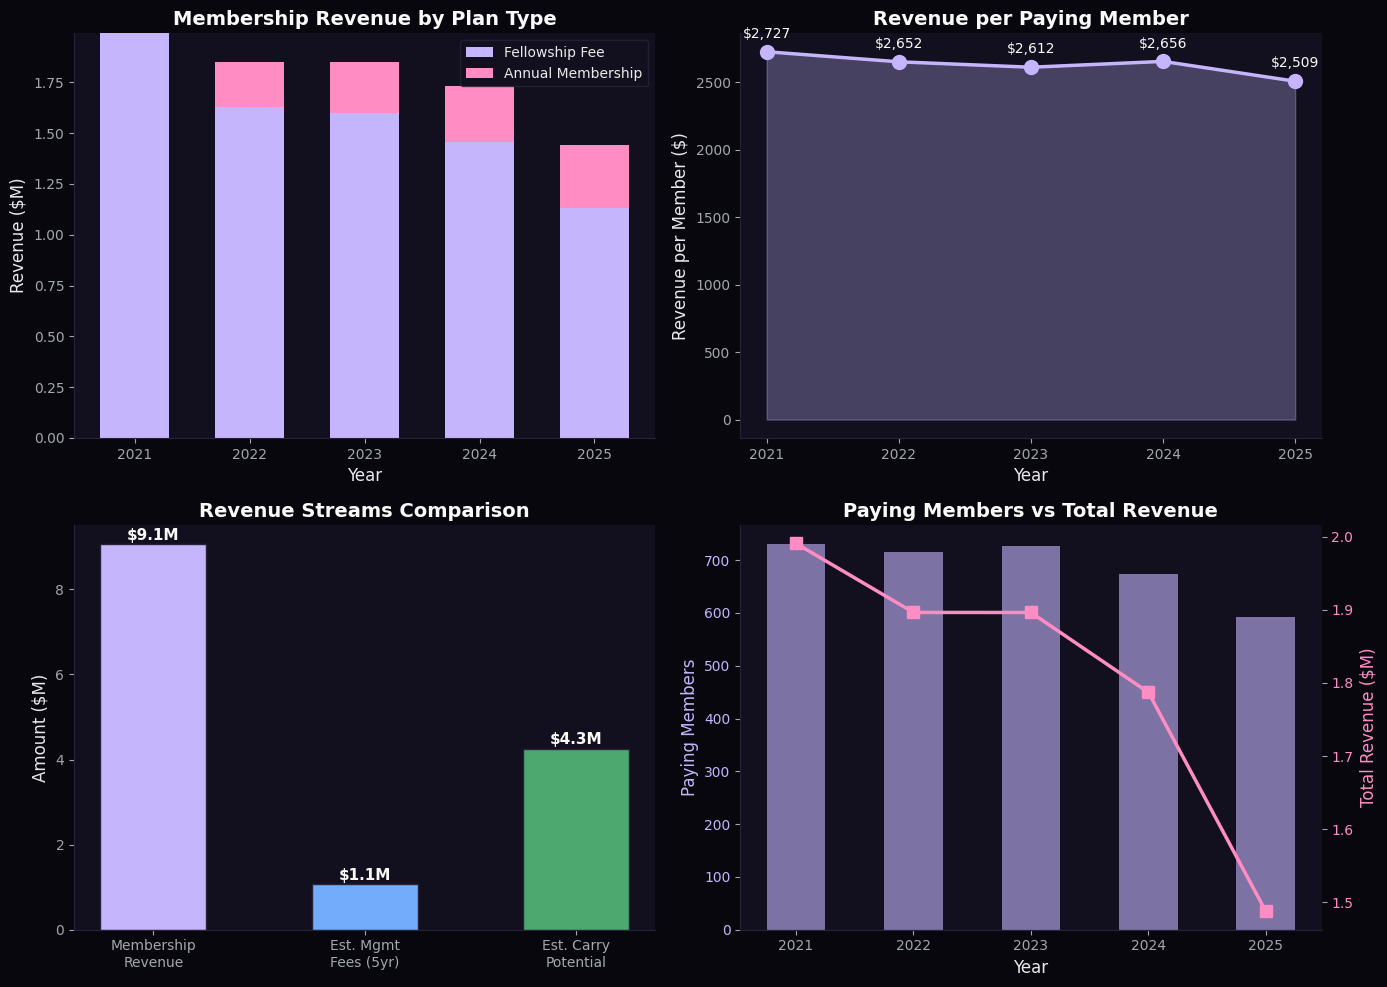


REVENUE & ECONOMICS SUMMARY

Total Membership Revenue (2021-2025): $9,058,660
Average Revenue per Member: $3,161

Fund Economics (Estimated):
  Total Alumni Fundraising: $1,063,942,308
  Estimated Fund AUM (1% of rounds): $10,639,423
  Potential Mgmt Fees (5yr @ 2%): $1,063,942
  Potential Carry (2x @ 20%): $4,255,769


In [15]:
# Visualize revenue trends and fund economics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Revenue by plan type over time (stacked bar)
ax = axes[0, 0]
years = revenue_summary['year'].values
width = 0.6
ax.bar(years, revenue_summary['fellowship_fee']/1e6, width, label='Fellowship Fee', color=COLORS['primary'])
ax.bar(years, revenue_summary['annual_membership']/1e6, width, bottom=revenue_summary['fellowship_fee']/1e6, 
       label='Annual Membership', color=COLORS['secondary'])
ax.set_xlabel('Year')
ax.set_ylabel('Revenue (\\$M)')
ax.set_title('Membership Revenue by Plan Type', fontweight='bold')
ax.legend(loc='upper right')
ax.set_xticks(years)

# 2. Revenue per member trend
ax = axes[0, 1]
ax.plot(years, revenue_summary['revenue_per_member'], marker='o', linewidth=2.5, 
        color=COLORS['primary'], markersize=10)
ax.fill_between(years, revenue_summary['revenue_per_member'], alpha=0.3, color=COLORS['primary'])
ax.set_xlabel('Year')
ax.set_ylabel('Revenue per Member (\\$)')
ax.set_title('Revenue per Paying Member', fontweight='bold')
ax.set_xticks(years)
for x, y in zip(years, revenue_summary['revenue_per_member']):
    ax.annotate(f'\\${y:,.0f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

# 3. Membership vs Fund Economics comparison
ax = axes[1, 0]
# Calculate total membership revenue
total_membership_revenue = paid_invoices['amount_usd'].sum()

# Estimate fund economics (typical 2% management fee on AUM, 20% carry on gains)
# On Deck invests in portfolio companies - estimate based on fundraising data
total_raised = outcomes[outcomes['outcome_type'] == 'fundraise']['amount_usd'].sum()
# Assume OD invests ~1% of rounds they facilitate, with 20% carry potential
estimated_fund_aum = total_raised * 0.01  # Conservative estimate
estimated_mgmt_fees = estimated_fund_aum * 0.02 * 5  # 2% over 5 years
estimated_carry_potential = estimated_fund_aum * 2 * 0.20  # 2x return, 20% carry

economics = {
    'Membership\nRevenue': total_membership_revenue / 1e6,
    'Est. Mgmt\nFees (5yr)': estimated_mgmt_fees / 1e6,
    'Est. Carry\nPotential': estimated_carry_potential / 1e6
}
bars = ax.bar(economics.keys(), economics.values(), color=[COLORS['primary'], COLORS['blue'], COLORS['green']], 
              width=0.5, edgecolor='#272336')
ax.set_ylabel('Amount (\\$M)')
ax.set_title('Revenue Streams Comparison', fontweight='bold')
for bar, val in zip(bars, economics.values()):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.1, f'\\${val:.1f}M', ha='center', fontsize=11, fontweight='bold')

# 4. Member growth and ARPU trend
ax = axes[1, 1]
ax2 = ax.twinx()
bars = ax.bar(years, revenue_summary['unique_members'], width=0.5, color=COLORS['primary'], alpha=0.6, label='Paying Members')
line = ax2.plot(years, revenue_summary['total']/1e6, marker='s', linewidth=2.5, color=COLORS['secondary'], 
                markersize=8, label='Total Revenue')
ax.set_xlabel('Year')
ax.set_ylabel('Paying Members', color=COLORS['primary'])
ax2.set_ylabel('Total Revenue (\\$M)', color=COLORS['secondary'])
ax.set_title('Paying Members vs Total Revenue', fontweight='bold')
ax.set_xticks(years)
ax.tick_params(axis='y', labelcolor=COLORS['primary'])
ax2.tick_params(axis='y', labelcolor=COLORS['secondary'])

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("REVENUE & ECONOMICS SUMMARY")
print("="*70)
print(f"\nTotal Membership Revenue (2021-2025): ${total_membership_revenue:,.0f}")
print(f"Average Revenue per Member: ${paid_invoices.groupby('member_id')['amount_usd'].sum().mean():,.0f}")
print(f"\nFund Economics (Estimated):")
print(f"  Total Alumni Fundraising: ${total_raised:,.0f}")
print(f"  Estimated Fund AUM (1% of rounds): ${estimated_fund_aum:,.0f}")
print(f"  Potential Mgmt Fees (5yr @ 2%): ${estimated_mgmt_fees:,.0f}")
print(f"  Potential Carry (2x @ 20%): ${estimated_carry_potential:,.0f}")